In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://docs.quantum-computing.ibm.com/run/primitives
# result = Sampler().run(circuits).result()

qiskit_runtime_service.__init__:INFO:2024-02-07 21:39:43,164: Default instance: ibm-q/open/main


In [2]:
import numpy as np
import qiskit
from qiskit import *
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
# from qiskit.providers.fake_provider import *
# from qiskit_aer.pulse import *
from qiskit.providers import *

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate, QuantumRegister
from qiskit import schedule

from qiskit.tools.monitor import job_monitor

from qiskit.tools.jupyter import *
%matplotlib inline

# from qiskit import IBMQ
import qiskit_ibm_provider
from qiskit_ibm_provider import IBMProvider
# IBMProvider.save_account(token=<INSERT_IBM_QUANTUM_TOKEN>)
provider = IBMProvider()
backend = provider.get_backend('ibm_brisbane')

backend_defaults = backend.defaults()

backend_properties = backend.properties()

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

qubit = 0

default_qubit_freq = backend_defaults.qubit_freq_est[qubit] # Default qubit frequency in Hz. 
print(f"Qubit {qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")

default_anharmonicity = backend_properties.qubits[qubit][3].value # Default anharmonicity in GHz
print(f"Default anharmonicity is {default_anharmonicity} GHz.")

# scale data (specific to each device)
scale_factor = 1e-7

# number of shots for our experiments
NUM_SHOTS = 1024

Qubit 0 has an estimated frequency of 4.721865844064552 GHz.
Default anharmonicity is -0.31197865973435573 GHz.


In [3]:
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result(timeout = 120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(np.real(job_results.get_memory(i)[qubit] * scale_factor))
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit] * scale_factor)
    return result_data

def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require 
    durations which are multiples of 16 samples.
    """
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [4]:
#####1->2 pulse

##Qubit 0 has an estimated frequency of 4.721863519574167 GHz.
##Default anharmonicity is -0.31197865973435573 GHz.
##Our updated estimate for the 1->2 transition frequency is 4.4096658 GHz.
##Pi Amplitude (1->2) = 0.24661863380316743

x12_duration = 160
x12_sigma = 40
qubit_12_freq = 4409665800
pi_amp_12 = 0.24661863380316743

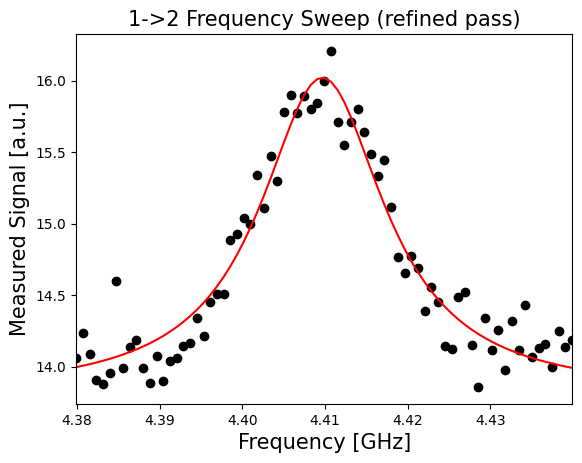

Our updated estimate for the 1->2 transition frequency is 4.4096681 GHz.


In [5]:
########discriminating states
#######################

####Computing the 1->2 frequency
##Excite the |1⟩ state by applying a 0 -> 1 π pulse. Then perform the frequency sweep over excitations of the |1⟩ state. 
##A single peak should be observed at a frequency lower than the 0 -> 1 frequency which corresponds to the 1 -> 2 frequency.
# smaller range sweep
num_freqs = 75
drive_power = 0.15
sweep_freqs = default_anharmonicity*GHz + np.linspace(-30*MHz, 30*MHz, num_freqs)

freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as freq12_sweep_sched:
    drive_chan = pulse.drive_channel(qubit)
    with pulse.frequency_offset(freq, drive_chan):
        pulse.play(pulse.Gaussian(duration=x12_duration,
                                  amp=drive_power,
                                  sigma=x12_sigma,
                                  name='x12_pulse'), drive_chan)

spect_gate = Gate("spect", 1, [freq])

# qc_spect = QuantumCircuit(1, 1)

# qc_spect.x(0)
# qc_spect.append(spect_gate, [0])
# qc_spect.measure(0, 0)
# qc_spect.add_calibration(spect_gate, (0,), freq12_sweep_sched, [freq])
    
# exp_spect_circs = [qc_spect.assign_parameters({freq: f}) for f in sweep_freqs]

# excited_freq_sweep_job = backend.run(exp_spect_circs, 
#                                      meas_level=1, 
#                                      meas_return='avg', 
#                                      shots=NUM_SHOTS)

# job_monitor(excited_freq_sweep_job)

job_id = "cpnc5mp9nad0008prgxg"
excited_freq_sweep_job = service.job(job_id)


# Get the refined data (average)
# plot and fit the refined signal, using the standard Lorentzian curve.
excited_freq_sweep_data = get_job_data(excited_freq_sweep_job, average=True)
excited_sweep_freqs = default_qubit_freq + default_anharmonicity*GHz + np.linspace(-30*MHz, 30*MHz, num_freqs)

def fit_function(x_values, y_values, function, init_params):
    """Fit a function using scipy curve_fit."""
    fitparams, conv = curve_fit(function, x_values, y_values, init_params, maxfev = 50000)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

# do fit in Hz
(excited_sweep_fit_params, 
 excited_sweep_y_fit) = fit_function(excited_sweep_freqs,
                                     excited_freq_sweep_data, 
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                     [-20, 4.625*GHz, 0.06*GHz, 3*GHz] # initial parameters for curve_fit
                                     )

# Note: we are only plotting the real part of the signal
plt.scatter(excited_sweep_freqs/GHz, excited_freq_sweep_data, color='black')
plt.plot(excited_sweep_freqs/GHz, excited_sweep_y_fit, color='red')
plt.xlim([min(excited_sweep_freqs/GHz), max(excited_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (refined pass)", fontsize=15)
plt.show()

_, qubit_12_freq, _, _ = excited_sweep_fit_params
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")

In [6]:
#######1->2 Rabi Experiment
##############################
##perform a Rabi experiment to obtain the π pulse amplitude for the 1 -> 2 transition.
##To do so, we apply a 0 → 1 π pulse and then sweep over drive amplitudes at the 1 -> 2 frequency.

# experimental configuration
num_rabi_points = 75 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 75 amplitudes evenly spaced from 0 to 1.0
drive_amp_min = 0
drive_amp_max = 1.0
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

amp = Parameter('amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Amp sweep') as rabi_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=amp,
                              sigma=x12_sigma,
                              name='x12_pulse'), drive_chan)
    
rabi_gate = Gate("rabi", 1, [amp])

qc_rabi = QuantumCircuit(1, 1)

qc_rabi.x(0)
qc_rabi.append(rabi_gate, [0])
qc_rabi.measure(0, 0)
qc_rabi.add_calibration(rabi_gate, (0,), rabi_sched, [amp])
    
exp_rabi_circs = [qc_rabi.assign_parameters({amp: a}) for a in drive_amps]

# rabi_12_job = backend.run(exp_rabi_circs, 
#                           meas_level=1, 
#                           meas_return='avg', 
#                           shots=NUM_SHOTS)

# job_monitor(rabi_12_job)

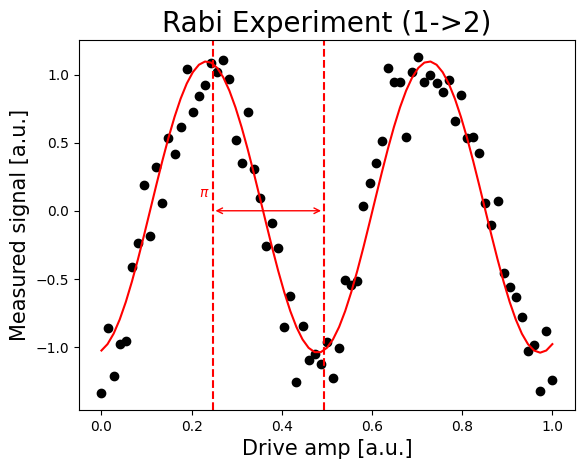

Our updated estimate for the 1->2 transition frequency is 4.4096681 GHz.
Pi Amplitude (1->2) = 0.24661863380316743


In [7]:
# Get the job data (average)
job_id = "cpnf0d99nad0008prpa0"
rabi_12_job = service.job(job_id)
rabi_12_data = get_job_data(rabi_12_job, average=True)

def baseline_remove(values):
    """Center data around 0."""
    return np.array(values) - np.mean(values)

# Note: Only real part of data is plotted
rabi_12_data = np.real(baseline_remove(rabi_12_data))
(rabi_12_fit_params, 
 rabi_12_y_fit) = fit_function(drive_amps,
                               rabi_12_data, 
                               lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                               [0.2, 0, 0.3, 0])

plt.scatter(drive_amps, rabi_12_data, color='black')
plt.plot(drive_amps, rabi_12_y_fit, color='red')

drive_12_period = rabi_12_fit_params[2] 

pi_amp_12 = drive_12_period/2

plt.axvline(pi_amp_12, color='red', linestyle='--')
plt.axvline(pi_amp_12+drive_12_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_12+drive_12_period/2, 0), xytext=(pi_amp_12,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp_12-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('Rabi Experiment (1->2)', fontsize=20)
plt.show()

print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")
print(f"Pi Amplitude (1->2) = {pi_amp_12}")

In [8]:
with pulse.build(backend=backend, default_alignment='sequential', name='x12 schedule') as x12_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=pi_amp_12,
                              sigma=x12_sigma,
                              name='x12_pulse'), drive_chan)
    
x12_gate = Gate("one_two_pulse", 1, [])

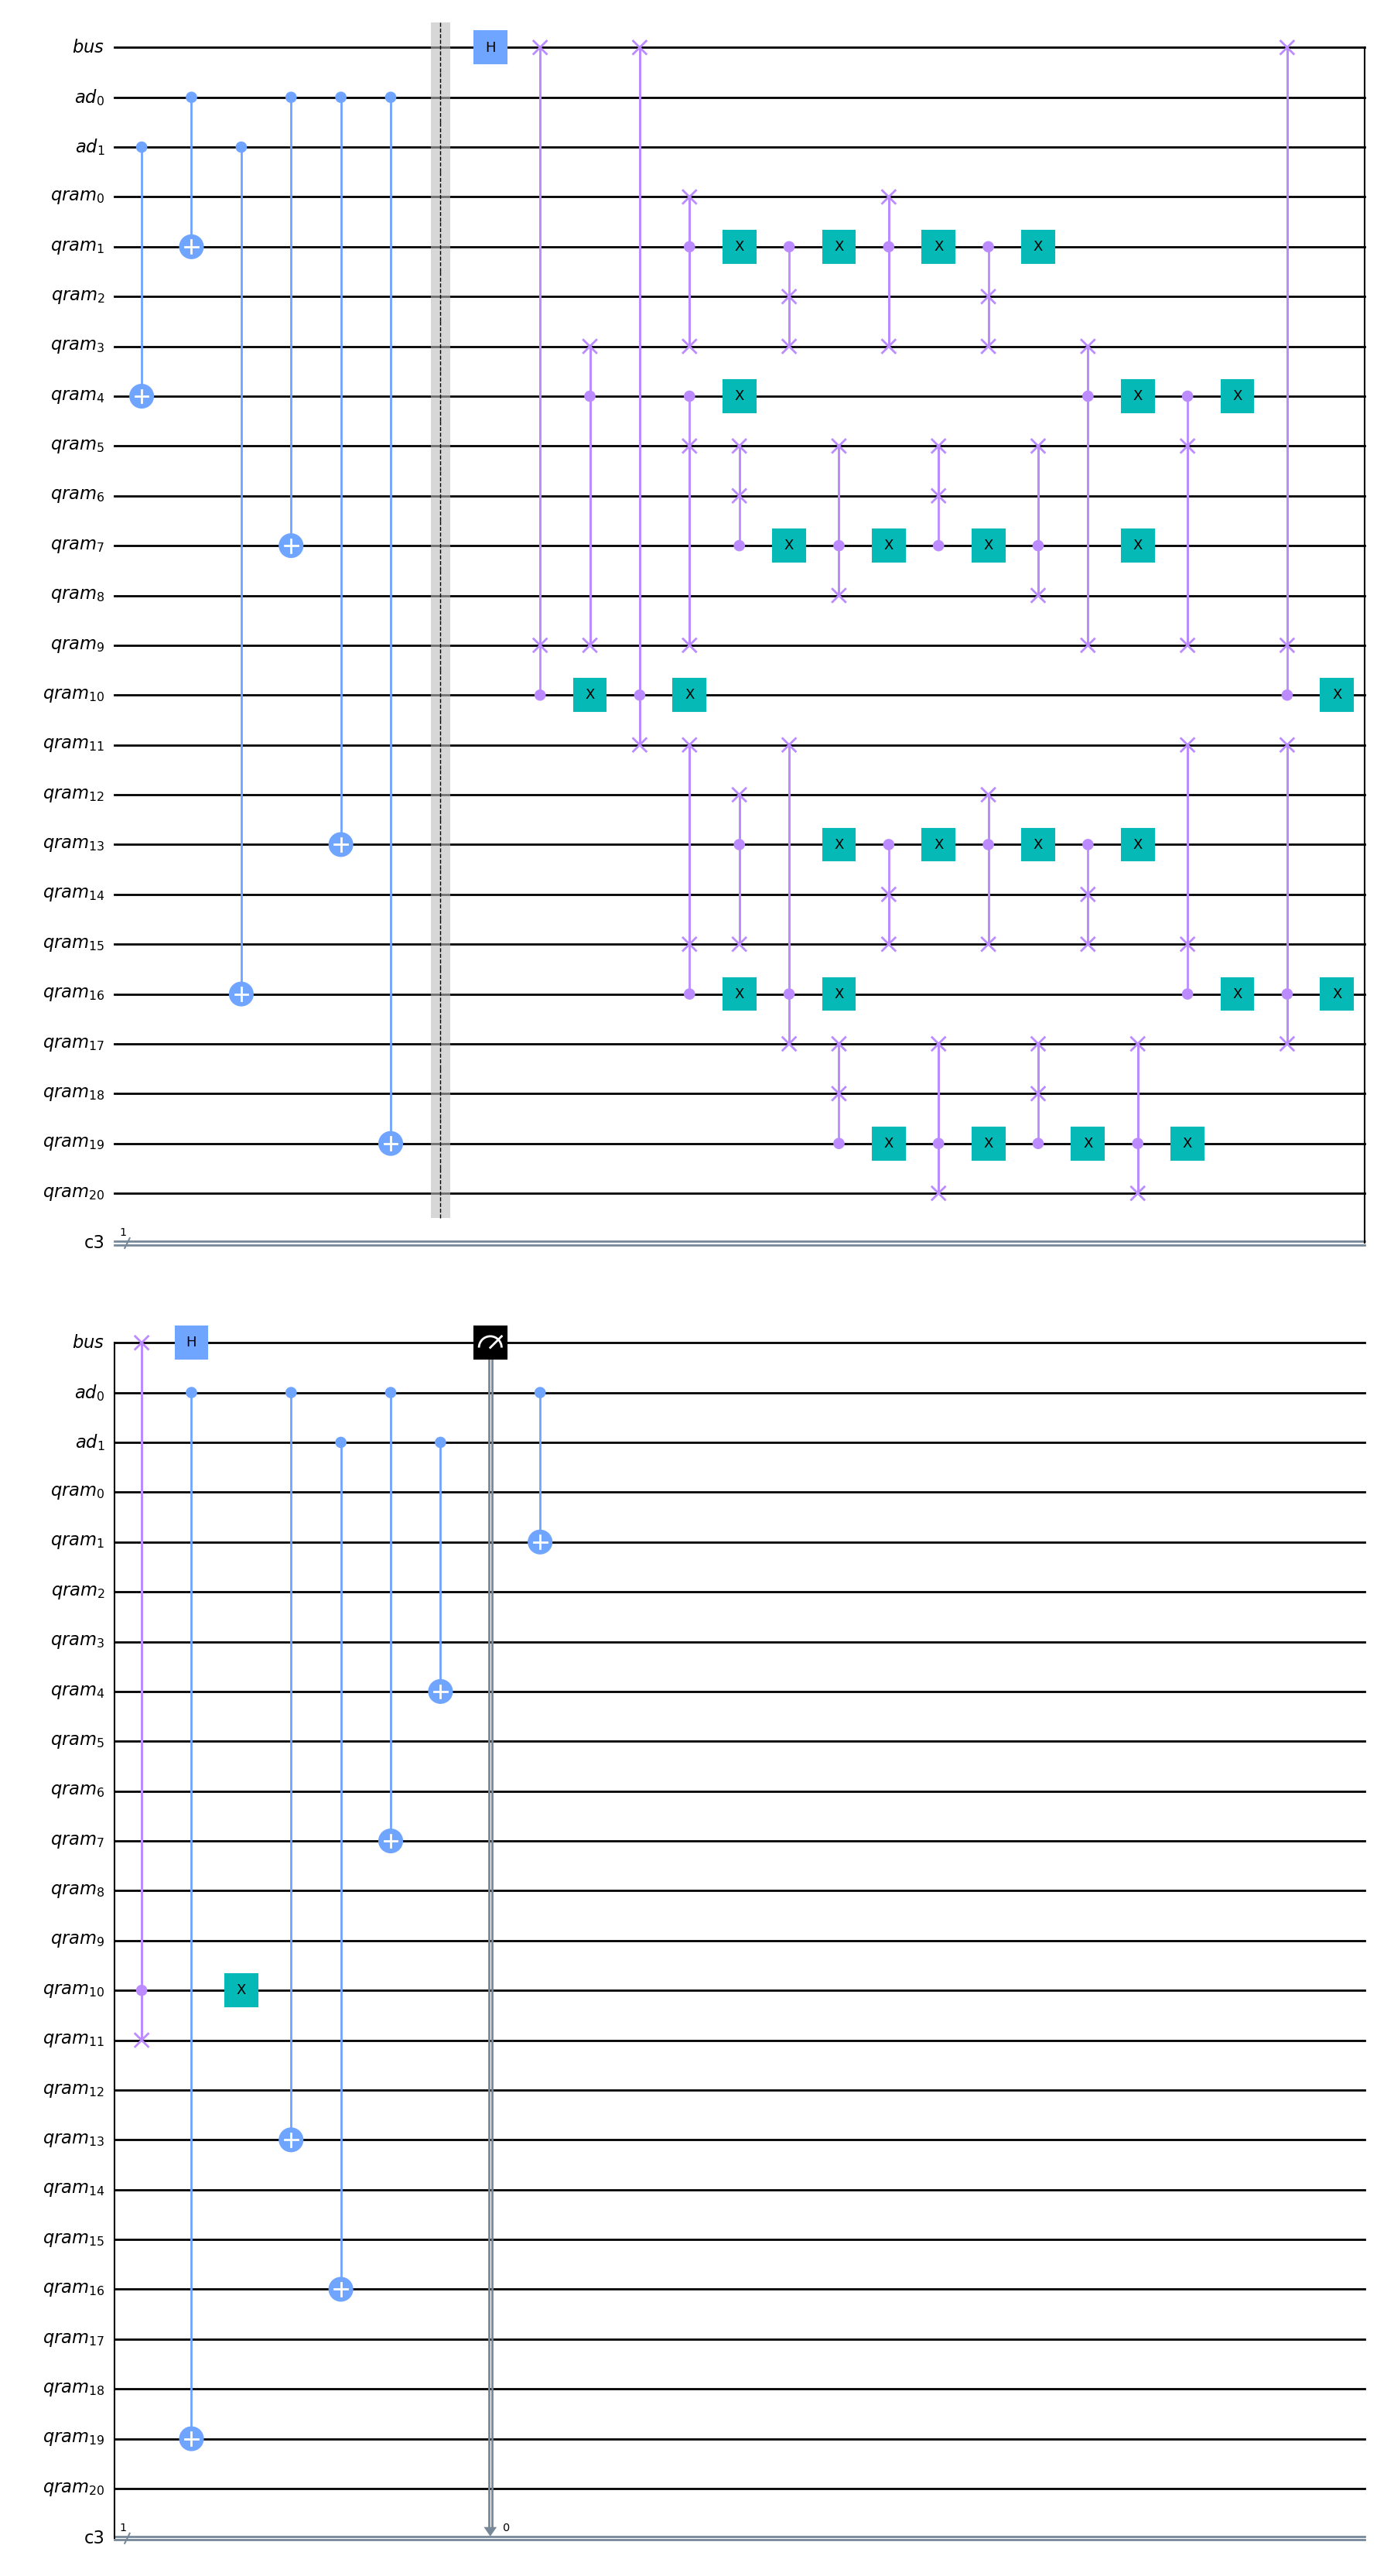

In [17]:
##qram
bus = QuantumRegister(1, name='bus')
ad = QuantumRegister(2, name='ad')
##ad2 = qram10
qram = QuantumRegister(21, name='qram')
data = ClassicalRegister(1)
qc = QuantumCircuit(bus,ad,qram,data)
qc1 = QuantumCircuit(bus,ad,qram,data)
qc_all_tr = QuantumCircuit(bus,ad,qram,data)

# # ##### bus = 2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
# qc1.x(bus)
# qc1.append(x12_gate, [0])
# qc1.add_calibration(x12_gate, (0,), x12_sched, [])
# qc1.draw()

#load address
qc.cx(ad[1], qram[4])
qc.cx(ad[1], qram[16])
qc.cx(ad[0], qram[1])
qc.cx(ad[0], qram[7])
qc.cx(ad[0], qram[13])
qc.cx(ad[0], qram[19])


qc.barrier()


# #retieve data
qc.h(bus)
qc.cswap(qram[10],qram[9],bus)
qc.x(qram[10])
qc.cswap(qram[10],qram[11],bus)
qc.x(qram[10])
qc.cswap(qram[4],qram[3],qram[9])
# qc.x(qram[4])
qc.cswap(qram[4],qram[5],qram[9])
qc.x(qram[4])
qc.cswap(qram[16],qram[15],qram[11])
qc.x(qram[16]) 
qc.cswap(qram[16],qram[17],qram[11])
qc.x(qram[16])
qc.cswap(qram[1],qram[3],qram[0])
qc.x(qram[1])
qc.cswap(qram[1],qram[3],qram[2])
qc.x(qram[1])
qc.cswap(qram[7],qram[6],qram[5])
qc.x(qram[7])
qc.cswap(qram[7],qram[8],qram[5])
qc.x(qram[7])
qc.cswap(qram[13],qram[12],qram[15])
qc.x(qram[13])
qc.cswap(qram[13],qram[14],qram[15])
qc.x(qram[13])
qc.cswap(qram[19],qram[18],qram[17])
qc.x(qram[19])
qc.cswap(qram[19],qram[20],qram[17])
qc.x(qram[19])

# qc.barrier()


# #data


# qc.barrier()


# #retreive data
qc.cswap(qram[1],qram[3],qram[0])
qc.x(qram[1])
qc.cswap(qram[1],qram[3],qram[2])
qc.x(qram[1])
qc.cswap(qram[7],qram[6],qram[5])
qc.x(qram[7])
qc.cswap(qram[7],qram[8],qram[5])
qc.x(qram[7])
qc.cswap(qram[13],qram[12],qram[15])
qc.x(qram[13])
qc.cswap(qram[13],qram[14],qram[15])
qc.x(qram[13])
qc.cswap(qram[19],qram[18],qram[17])
qc.x(qram[19])
qc.cswap(qram[19],qram[20],qram[17])
qc.x(qram[19])
qc.cswap(qram[4],qram[3],qram[9])
qc.x(qram[4])
qc.cswap(qram[4],qram[5],qram[9])
qc.x(qram[4])
qc.cswap(qram[16],qram[15],qram[11])
qc.x(qram[16]) 
qc.cswap(qram[16],qram[17],qram[11])
qc.x(qram[16])
qc.cswap(qram[10],qram[9],bus)
qc.x(qram[10])
qc.cswap(qram[10],qram[11],bus)
qc.x(qram[10])
qc.h(bus)

# qc.barrier()

qc.cx(ad[0], qram[19])
qc.cx(ad[0], qram[13])
qc.cx(ad[0], qram[7])
qc.cx(ad[0], qram[1])
qc.cx(ad[1], qram[16])
qc.cx(ad[1], qram[4])

qc.measure(0,0)
qc.draw()

######transpile
# qc_tr1 = transpile(qc1, backend)
# qc_tr = transpile(qc, backend)
# qc_all_tr = qc_tr1.compose(qc_tr)
# qc_all_tr.draw()

In [10]:
# job_02 = backend.run([qc_all_tr], 
#                      meas_level=1, 
#                      meas_return='single', 
#                      ############
#                      shots=NUM_SHOTS)
# job_monitor(job_02)

##measure all
#####bus = 2, cpvaszz9nad0008vq3qg
#####bus = 1, cpvz8t31tcz00080dd20
#####bus = 0, cpw28v3dmm10008y7m00

###一半bus = 2, cpwh2ma0f6rg008x9p60
###bus = 1, cpwhgntdmm10008xdn1g
###bus = 0, cpwjmdssp83g008aze70


####measure bus
######bus = 2, cq1x7k67z1hg00827660
######bus = 1, cq1yye97z1hg0086zn7g
######bus = 0, cq1zfrf7z1hg008ns6a0



/tmp/ipykernel_334/1268691050.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(zero_data), np.imag(zero_data),
/tmp/ipykernel_334/1268691050.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(one_data), np.imag(one_data),
/tmp/ipykernel_334/1268691050.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(two_data), np.imag(two_data),
/tmp/ipykernel_334/1268691050.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(mean_zero), np.imag(mean_zero),
/tmp/ipykernel_334/1268691050.py:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(mean_one), np.imag(mean_one),
/tmp/ipykernel_334/1268691050.py:35: UserWarning: No data for colormapping provided via 'c'. Paramete

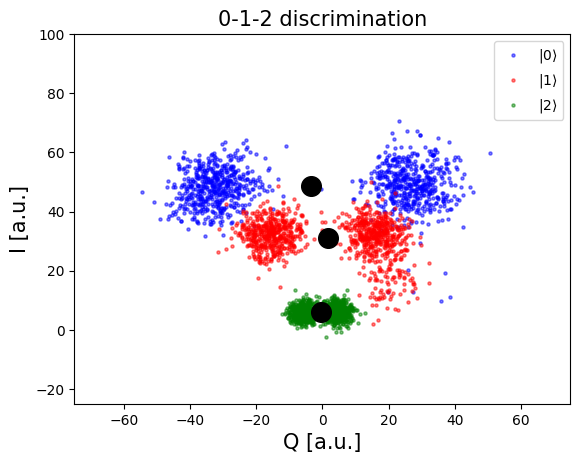

In [11]:
# # Get job data (single); split for zero, one and two
# job_id = "cpvaszz9nad0008vq3qg"
# IQ_2_job = service.job(job_id)
# two_data = get_job_data(IQ_2_job, average=False)

# job_id = "cpvz8t31tcz00080dd20"
# IQ_1_job = service.job(job_id)
# one_data = get_job_data(IQ_1_job, average=False)

# job_id = "cpw28v3dmm10008y7m00"
# IQ_0_job = service.job(job_id)
# zero_data = get_job_data(IQ_0_job, average=False)

# def IQ_012_plot(x_min, x_max, y_min, y_max):
#     """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
#     as arguments."""
#     # zero data plotted in blue
#     plt.scatter(np.real(zero_data), np.imag(zero_data), 
#                     s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
#     # one data plotted in red
#     plt.scatter(np.real(one_data), np.imag(one_data), 
#                     s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
#     # two data plotted in green
#     plt.scatter(np.real(two_data), np.imag(two_data), 
#                     s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')

#     # Plot a large dot for the average result of the 0, 1 and 2 states.
#     mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
#     mean_one = np.mean(one_data)
#     mean_two = np.mean(two_data)
#     plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
#                 s=200, cmap='viridis', c='black',alpha=1.0)
#     plt.scatter(np.real(mean_one), np.imag(mean_one), 
#                 s=200, cmap='viridis', c='black',alpha=1.0)
#     plt.scatter(np.real(mean_two), np.imag(mean_two), 
#                 s=200, cmap='viridis', c='black',alpha=1.0)
    
#     plt.xlim(x_min, x_max)
#     plt.ylim(y_min,y_max)
#     plt.legend()
#     plt.ylabel('I [a.u.]', fontsize=15)
#     plt.xlabel('Q [a.u.]', fontsize=15)
#     plt.title("0-1-2 discrimination", fontsize=15)
    
# x_min = -75
# x_max = 75
# y_min = -25
# y_max = 100
# IQ_012_plot(x_min, x_max, y_min, y_max)


/tmp/ipykernel_334/3513576358.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(zero_data), np.imag(zero_data),
/tmp/ipykernel_334/3513576358.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(one_data), np.imag(one_data),
/tmp/ipykernel_334/3513576358.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(two_data), np.imag(two_data),
/tmp/ipykernel_334/3513576358.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(mean_zero), np.imag(mean_zero),
/tmp/ipykernel_334/3513576358.py:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(mean_one), np.imag(mean_one),
/tmp/ipykernel_334/3513576358.py:35: UserWarning: No data for colormapping provided via 'c'. Paramete

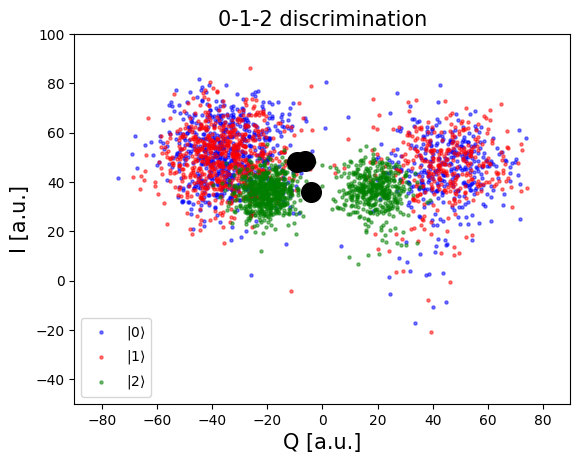

In [13]:
# # Get job data (single); split for zero, one and two
# job_id = "cpwh2ma0f6rg008x9p60"
# IQ_2_job = service.job(job_id)
# two_data = get_job_data(IQ_2_job, average=False)

# job_id = "cpwhgntdmm10008xdn1g"
# IQ_1_job = service.job(job_id)
# one_data = get_job_data(IQ_1_job, average=False)

# job_id = "cpwjmdssp83g008aze70"
# IQ_0_job = service.job(job_id)
# zero_data = get_job_data(IQ_0_job, average=False)

# def IQ_012_plot(x_min, x_max, y_min, y_max):
#     """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
#     as arguments."""
#     # zero data plotted in blue
#     plt.scatter(np.real(zero_data), np.imag(zero_data), 
#                     s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
#     # one data plotted in red
#     plt.scatter(np.real(one_data), np.imag(one_data), 
#                     s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
#     # two data plotted in green
#     plt.scatter(np.real(two_data), np.imag(two_data), 
#                     s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')

#     # Plot a large dot for the average result of the 0, 1 and 2 states.
#     mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
#     mean_one = np.mean(one_data)
#     mean_two = np.mean(two_data)
#     plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
#                 s=200, cmap='viridis', c='black',alpha=1.0)
#     plt.scatter(np.real(mean_one), np.imag(mean_one), 
#                 s=200, cmap='viridis', c='black',alpha=1.0)
#     plt.scatter(np.real(mean_two), np.imag(mean_two), 
#                 s=200, cmap='viridis', c='black',alpha=1.0)
    
#     plt.xlim(x_min, x_max)
#     plt.ylim(y_min,y_max)
#     plt.legend()
#     plt.ylabel('I [a.u.]', fontsize=15)
#     plt.xlabel('Q [a.u.]', fontsize=15)
#     plt.title("0-1-2 discrimination", fontsize=15)
    
# x_min = -90
# x_max = 90
# y_min = -50
# y_max = 100
# IQ_012_plot(x_min, x_max, y_min, y_max)


/tmp/ipykernel_334/3703798193.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(zero_data), np.imag(zero_data),
/tmp/ipykernel_334/3703798193.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(one_data), np.imag(one_data),
/tmp/ipykernel_334/3703798193.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(two_data), np.imag(two_data),
/tmp/ipykernel_334/3703798193.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(mean_zero), np.imag(mean_zero),
/tmp/ipykernel_334/3703798193.py:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(mean_one), np.imag(mean_one),
/tmp/ipykernel_334/3703798193.py:35: UserWarning: No data for colormapping provided via 'c'. Paramete

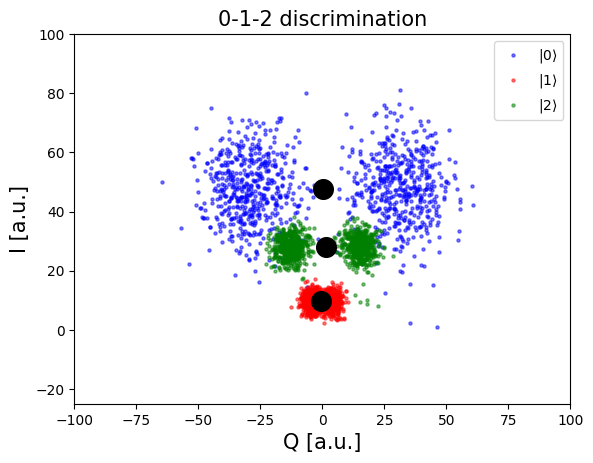

In [14]:
# Get job data (single); split for zero, one and two
job_id = "cq1x7k67z1hg00827660"
IQ_2_job = service.job(job_id)
two_data = get_job_data(IQ_2_job, average=False)

job_id = "cq1yye97z1hg0086zn7g"
IQ_1_job = service.job(job_id)
one_data = get_job_data(IQ_1_job, average=False)

job_id = "cq1zfrf7z1hg008ns6a0"
IQ_0_job = service.job(job_id)
zero_data = get_job_data(IQ_0_job, average=False)

def IQ_012_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    plt.scatter(np.real(zero_data), np.imag(zero_data), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data), 
                    s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_two), np.imag(mean_two), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)
    
x_min = -100
x_max = 100
y_min = -25
y_max = 100
IQ_012_plot(x_min, x_max, y_min, y_max)
